<img src="header.png" align="left"/>

# Exercise: Classification of MNIST (10 points)


Die goal of this exercise is to create a simple image classification network and to work on the improvement of a model and how to debug and check the training data. We start with a simple CNN model for digit classification of the MNIST dataset [1].  This dataset contains 60,000 scans of digits for training and 10,000 scans of digits for validation. A sample consists of 28x28 features with values between 0 and 255, note that the features are inverted. Actually digits are rather dark on a light background. MNIST digits are light on a dark background.
This example is partly based on a tutorial by Jason Brownlee [2]. 
Please follow the instructions in the notebook.


```
[1] http://yann.lecun.com/exdb/mnist/
[2] https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/
```

**NOTE**

Document your results by simply adding a markdown cell or a python cell (as comment) and writing your statements into this cell. For some tasks the result cell is already available.




In [1]:
#
# Import some modules
#
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import model_from_json
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#
# Turn off errors and warnings (does not work sometimes)
#
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=Warning)

#
# Diagram size
#
plt.rcParams['figure.figsize'] = [16, 9]


#
# nasty hack for macos
#
os.environ['KMP_DUPLICATE_LIB_OK']='True'

#
# check version
#
print('starting notebook with tensorflow version {}'.format(tf.version.VERSION))

starting notebook with tensorflow version 2.0.0


# Load and prepare data

In [2]:
#
# Loading of the data (very simplified) with split into train and test data (fixed split)
#
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
#
# Check some data
#
x_train[0][11]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 139, 253,
       190,   2,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0], dtype=uint8)

In [4]:
#
# Print shapes of data
#
print('training data: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('test     data: X=%s, y=%s' % (x_test.shape, y_test.shape))

training data: X=(60000, 28, 28), y=(60000,)
test     data: X=(10000, 28, 28), y=(10000,)


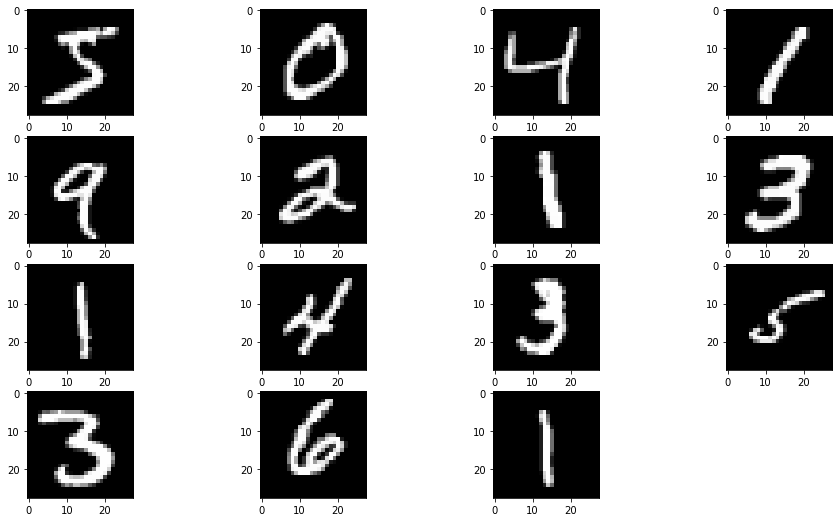

In [5]:
#
# Display some examples of the data
#
for i in range(15):
    plt.subplot(4,4,1 + i)
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
plt.show()

In [6]:
#
# Display labels of some data
#
for i in range(15):
    print('label {}'.format(y_train[i]))

label 5
label 0
label 4
label 1
label 9
label 2
label 1
label 3
label 1
label 4
label 3
label 5
label 3
label 6
label 1


# Task: Plot a histogram of the classes of the training data (1 point)

After plotting, give a short estimation if this distribution is OK for use in a classification situation.

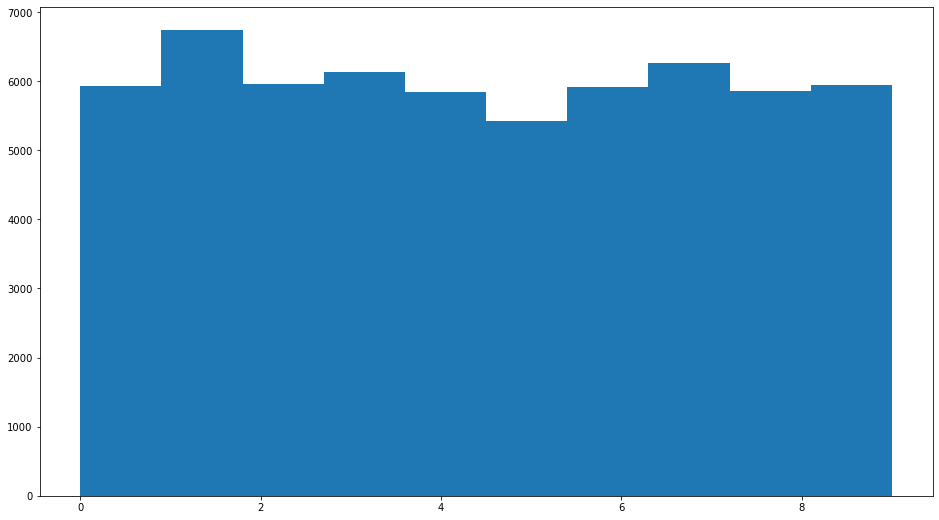

In [7]:
#
# Histogram of class counts (digits)
#
# Task: plot the histogram as array or as plot
#

plt.hist(y_train)  # arguments are passed to np.histogram
plt.show()

# Prepare data for classification (1 point)

In [8]:
# 
# Change shape of data for model
#
print(x_train.shape[0])
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))
#
# Task: find out why the unusual shap of the input data is required? Why is (-1,28,28) not sufficien? (1 point)
# give a short description here in the comment.
# Hint: check the tensorflow keras documentation about 2D cnn layer.
#

60000


### Antwort:
sonst weiß man nicht wieviele color-channels ein Pixel des Bildes hat ( in diesem Fall 1 color-channel -> schwarz/weiß ), wenn die Bilder RBG wären, hätt man 28,28,3, für jeweils einen Farbkanal einen Zahlenwert.
der CNN layer erwartet ein Array weil er für Farbbilder konzipiert wurde (mehrere Farkanäle)

In [9]:
print(x_train.shape[0])

60000


In [10]:
# 
# Scale pixel values into range of 0 to 1
#
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255.0
x_test = x_test / 255.0

In [11]:
# check one transformed sample
x_train[0]

array([[[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        

In [12]:
# 
# One-hot encoding for classes
#
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

In [13]:
# check the one-hot encoding
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

# Build the first model (2 points)

In [14]:
#
# Simple CNN model
#
# Task: complete the code for a simple CNN network with one CNN layer.
# Hint: look for examples in the internet or in the slides.
#
num_filters = 32
filter_size = 3
pool_size = 2

model = Sequential()

model.add(Conv2D(num_filters, filter_size, input_shape=x_train.shape[1:], activation='relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(10, activation='softmax'))

In [15]:
# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
# train model
history = model.fit(x_train, y_train, batch_size=128, epochs=5 )

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 15s 252us/sample - loss: 0.2209 - accuracy: 0.9381
Epoch 2/5
60000/60000 [==============================] - 15s 246us/sample - loss: 0.0676 - accuracy: 0.9798
Epoch 3/5
60000/60000 [==============================] - 15s 247us/sample - loss: 0.0473 - accuracy: 0.9857
Epoch 4/5
60000/60000 [==============================] - 15s 248us/sample - loss: 0.0353 - accuracy: 0.9893
Epoch 5/5
60000/60000 [==============================] - 15s 248us/sample - loss: 0.0265 - accuracy: 0.9922


In [17]:
# get a short summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5408)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               540900    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 542,230
Trainable params: 542,230
Non-trainable params: 0
_________________________________________________________________


# First prediction with model (1 point)

In [18]:
# predict on data (one sample)
#
# Task: describe the meaning of the numbers returned from the prediction. (1 point)
# write your findings here in the comments
# Hint: look at the definition of the output layer (last layer) in the model.
#
model.predict(x_train[1:2])

array([[9.9999738e-01, 1.7990731e-08, 2.3174609e-06, 7.9504595e-08,
        6.4538493e-11, 1.9060166e-10, 2.0572833e-07, 3.4572373e-08,
        1.5277655e-08, 7.9483780e-09]], dtype=float32)

### Antwort:
liefert ein Array zurück von 10 Werten ( wir wollen ja die Ziffern 0-9 predicten ), und jeder Wert veranschaulicht zu wie viel Prozent der gewisse Eintrage die gesuchte Nummer ist. ( z.B. zu 95% ist es "1" zu 3% eine "7", etc.. ) 

In [19]:
# compare with expexted result
y_train[1:2]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [20]:
#
# Measure the accuracy
#
loss, acc = model.evaluate(x_test, y_test, verbose=0)
print('accuracy {:.5f}, loss {:.5f}'.format(acc, loss))

accuracy 0.98590, loss 0.04241


In [21]:
#
# Estimate the number of false classifications in production use
#
print('with {} samples there are about {:.0f} false classifications to expect.'.format( x_test.shape[0], (x_test.shape[0]*(1-acc))))

with 10000 samples there are about 141 false classifications to expect.


# Print out training progress

In [22]:
#
# Plot loss and accuracy
#
def summarize_diagnostics(history,modelname):
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='green', label='train')
    plt.subplots_adjust(hspace=0.5)
    plt.savefig( 'results/' + modelname + '_plot.png')
    plt.show()
    plt.close()

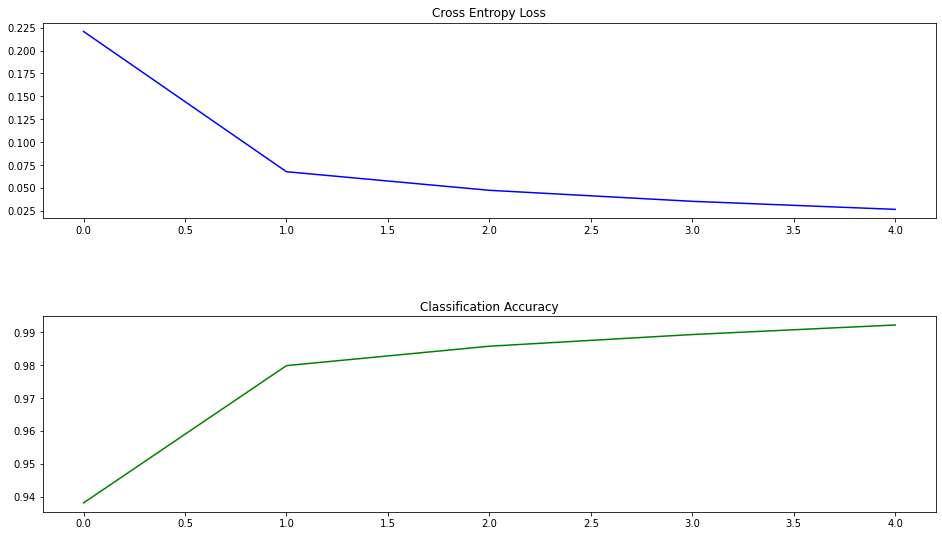

In [23]:
summarize_diagnostics(history,'03_model1')

# Task: Improve the model significantly (2 points)

Your customer requires to have less than 1% of wrong classifications. Start to build a better model with significantly less than 100 wrong classifications in the 10000 test samples. Research the internet for the optimal model setup for MNIST classification and try to replicate this model here. Make sure to document the source where you found the hints for the improvement (links to sources).

In [24]:
#
# Setup new model
#

def create_model_2():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    return model

In [25]:
# instantiate model
model2 = create_model_2()

In [26]:

# compile
opt = SGD(lr=0.01, momentum=0.9)
model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
#model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
# train with history
history = model2.fit(x_train, y_train, batch_size=128, epochs=15 )

Train on 60000 samples
Epoch 1/15
60000/60000 [==============================] - 41s 681us/sample - loss: 0.2049 - accuracy: 0.9360
Epoch 2/15
60000/60000 [==============================] - 41s 683us/sample - loss: 0.0634 - accuracy: 0.9802
Epoch 3/15
60000/60000 [==============================] - 40s 668us/sample - loss: 0.0452 - accuracy: 0.9863
Epoch 4/15
60000/60000 [==============================] - 40s 665us/sample - loss: 0.0340 - accuracy: 0.9894
Epoch 5/15
60000/60000 [==============================] - 40s 664us/sample - loss: 0.0276 - accuracy: 0.9915
Epoch 6/15
60000/60000 [==============================] - 40s 665us/sample - loss: 0.0233 - accuracy: 0.9930
Epoch 7/15
60000/60000 [==============================] - 42s 697us/sample - loss: 0.0194 - accuracy: 0.9941
Epoch 8/15
60000/60000 [==============================] - 41s 690us/sample - loss: 0.0155 - accuracy: 0.9954
Epoch 9/15
60000/60000 [==============================] - 43s 714us/sample - loss: 0.0131 - accuracy: 0.9

In [28]:
#
# Measure the accuracy
#
loss, acc = model2.evaluate(x_test, y_test, verbose=0)
print('Accuracy {:.5f}, loss: {:.5f}'.format(acc, loss))

Accuracy 0.99120, loss: 0.03076


In [29]:
#
# Estimate the number of false classifications in production use
#
print('with {} samples there are about {:.0f} false classifications to expect.'.format( x_test.shape[0], (x_test.shape[0]*(1-acc))))

with 10000 samples there are about 88 false classifications to expect.


# Antwort: von der [URL](https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/) aus der Angabe in diesem notebook.

* 2 zusätzliche CNN layers nach dem ersten MaxPool und danach ein weiter Max-pool
* mehr Trainings-Epochen ( 5 statt 15 )
* custom optimiser anstatt 'adam' optimizer beim kompilieren

In [30]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)              

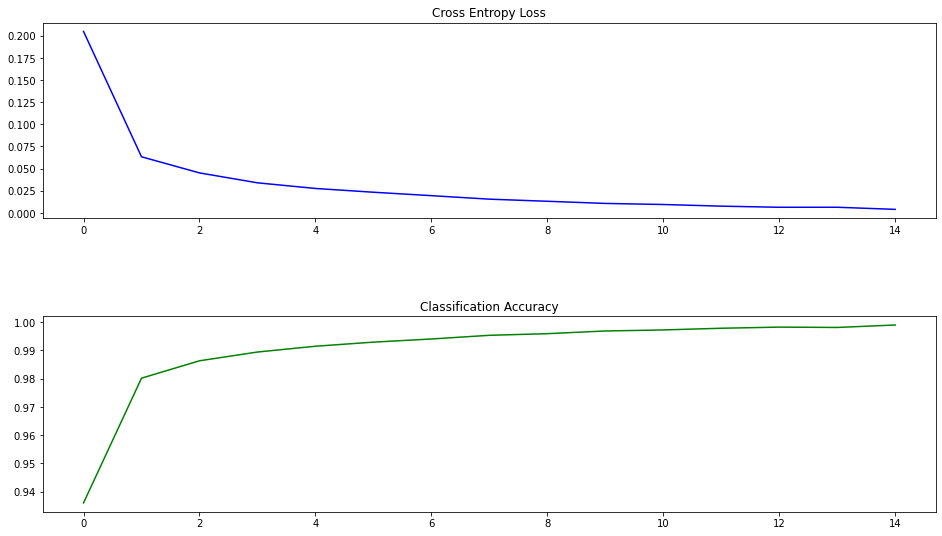

In [31]:
summarize_diagnostics(history,'03_model2')

# Save the model

In [32]:
#
# Save a model for later use
#
prefix = 'results/03_'
modelName = prefix + "model.json"
weightName = prefix + "model.h5"

# set to True if the model should be saved
save_model = False
if save_model:
    model_json = model2.to_json()
    with open( modelName , "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model2.save_weights( weightName )
    print("saved model to disk as {} {}".format(modelName,weightName))
    
else:

    # load model (has to be saved before, model is not part of git)    
    json_file = open(modelName, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model2 = model_from_json(loaded_model_json)
    # load weights into new model
    model2.load_weights(weightName)
    print("loaded model from disk")
    

loaded model from disk


# Task: Find characteristics in the errors of the model (1 point)

There are still too many false classifications using the model. Evaluate all test data and plot examples of failed classifications to get a better undestanding what goes wring. Plot a confusion matrix to get a better insight.

In [33]:
y_test_predictions = model2.predict(x_test)

In [34]:
#
# generate confusion matrix
# Task: find a suitable function for generating a confusion matrix as array
# 
confusion = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(y_test_predictions, axis=1))

In [35]:
print(confusion)

[[ 976    0    0    0    0    1    0    1    2    0]
 [   0 1133    1    0    0    0    1    0    0    0]
 [   1    0 1030    0    0    0    0    1    0    0]
 [   1    0    2  999    0    4    0    0    3    1]
 [   0    0    1    0  979    0    0    0    0    2]
 [   1    0    0    4    0  884    1    0    0    2]
 [   4    2    0    0    4    2  945    0    1    0]
 [   0    5    3    0    0    0    0 1016    1    3]
 [   3    0    2    0    0    0    0    1  964    4]
 [   0    0    0    2    5    3    0    0    0  999]]


In [36]:
# make a nice plot of the confusion matrix
import itertools
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


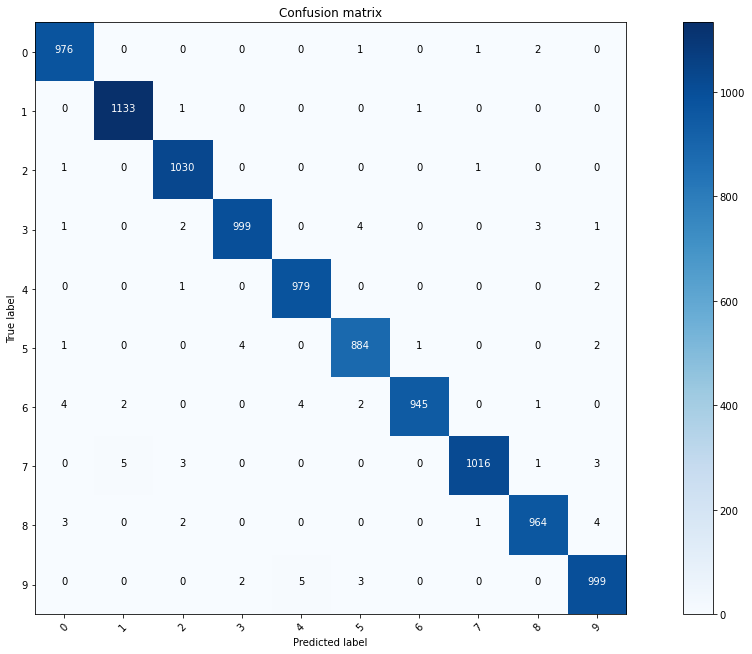

In [37]:
# plot confusion matrix
plot_confusion_matrix(confusion,['0','1','2','3','4','5','6','7','8','9'] )

# Task: Update your training strategy (2 points)

Beside many other options, there are two streight forward ways to improve your model:

1. Add more data for those classes which are poorely classified
1. Add augmentation for the training data

Implement the augmentation strategy and test if there is an improvement.


## Augmentation

Task: Search the internet for the ImageDataGenerator class of the Keras framework and implement such a generator for the training of the model. Select suitable augmentation which fits to the use-case. 
Document the resulting accuracy.

In [38]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [39]:
# instantiate model
model3 = create_model_2()
model3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [40]:
# fits the model on batches with real-time data augmentation:
batch_size = 32
epochs = 20

model3.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
          steps_per_epoch=len(x_train) / batch_size, epochs=epochs)

Train for 1875.0 steps
Epoch 1/20
1875/1875 [==============================] - 59s 32ms/step - loss: 0.6956 - accuracy: 0.7649
Epoch 2/20
1875/1875 [==============================] - 56s 30ms/step - loss: 0.2789 - accuracy: 0.9130
Epoch 3/20
1875/1875 [==============================] - 55s 30ms/step - loss: 0.2075 - accuracy: 0.9346
Epoch 4/20
1875/1875 [==============================] - 56s 30ms/step - loss: 0.1724 - accuracy: 0.9467
Epoch 5/20
1875/1875 [==============================] - 55s 30ms/step - loss: 0.1550 - accuracy: 0.9518
Epoch 6/20
1875/1875 [==============================] - 56s 30ms/step - loss: 0.1440 - accuracy: 0.9553
Epoch 7/20
1875/1875 [==============================] - 56s 30ms/step - loss: 0.1308 - accuracy: 0.9590
Epoch 8/20
1875/1875 [==============================] - 57s 30ms/step - loss: 0.1263 - accuracy: 0.9606
Epoch 9/20
1875/1875 [==============================] - 55s 30ms/step - loss: 0.1195 - accuracy: 0.9620
Epoch 10/20
1875/1875 [==================

In [41]:
#
# Evaluierung
#
loss, acc = model3.evaluate(x_test, y_test, verbose=0)
print('accuracy {:.3f}, loss: {:.3f} '.format(acc, loss) )

accuracy 0.984, loss: 0.049 


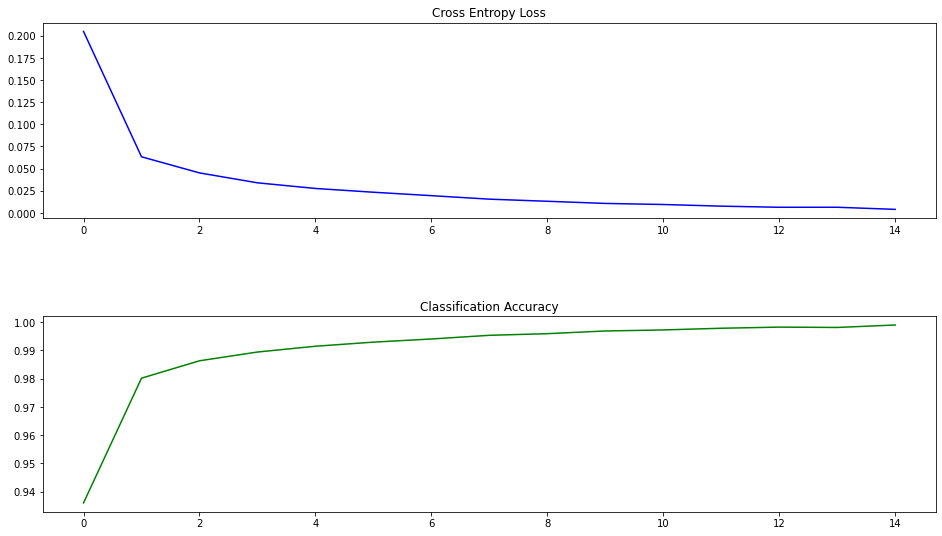

In [42]:
summarize_diagnostics(history,'03_model3')

In [43]:
y_test_predictions = model3.predict(x_test)

In [44]:
# generate confusion matrix
confusion = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(y_test_predictions,axis=1))

Confusion matrix, without normalization


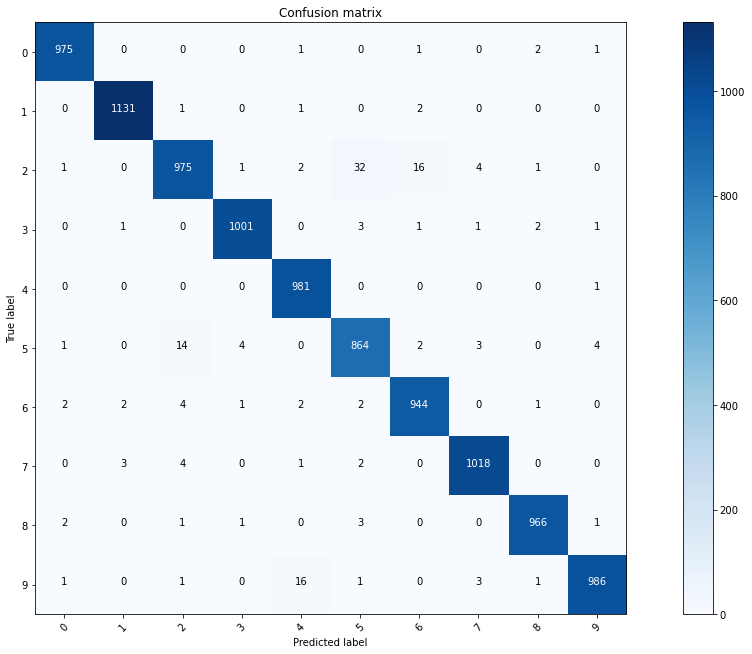

In [45]:
# plot confusion matrix
plot_confusion_matrix(confusion,['0','1','2','3','4','5','6','7','8','9'] )